Analyze the chromatic resolution data generated from Zemax by running Chromatic Resolution Zemax.py

In [1]:
import numpy as np
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt

In [10]:
# Filepath to the output data stored in a numpy array
filePath = 'TIM_ChromaticResData.npy'
# data is stored in a dictionary with the keys: 'SW' and 'LW', which are dictionaries, 
# each with keys, 'SFNO', 'TFNO', 'CENX', and 'CENY'. Each entry is a numpy array 
# whose rows are fields and columns are wavelegnths
data = np.load(filePath).item() 
# Accidental switching of names when generating data, so switch back here until new data is collected.
SWdata = data['LW']
LWdata = data['SW']
# Flip the orientation of the X axis of the SW module
SWdata['CENX'] = -1*SWdata['CENX']
numFields = len(SWdata['CENX'])
numWavs = len(SWdata['CENX'][0])
# Parameters used to generate data
SW1 = 240
SW2 = 317
LW1 = 317
LW2 = 420
F1 = -0.18
F2 = 0.18
wavs_SW = np.linspace(SW1,SW2,numWavs)
wavs_LW = np.linspace(LW1,LW2,numWavs)
fields = np.linspace(F1,F2,numFields)

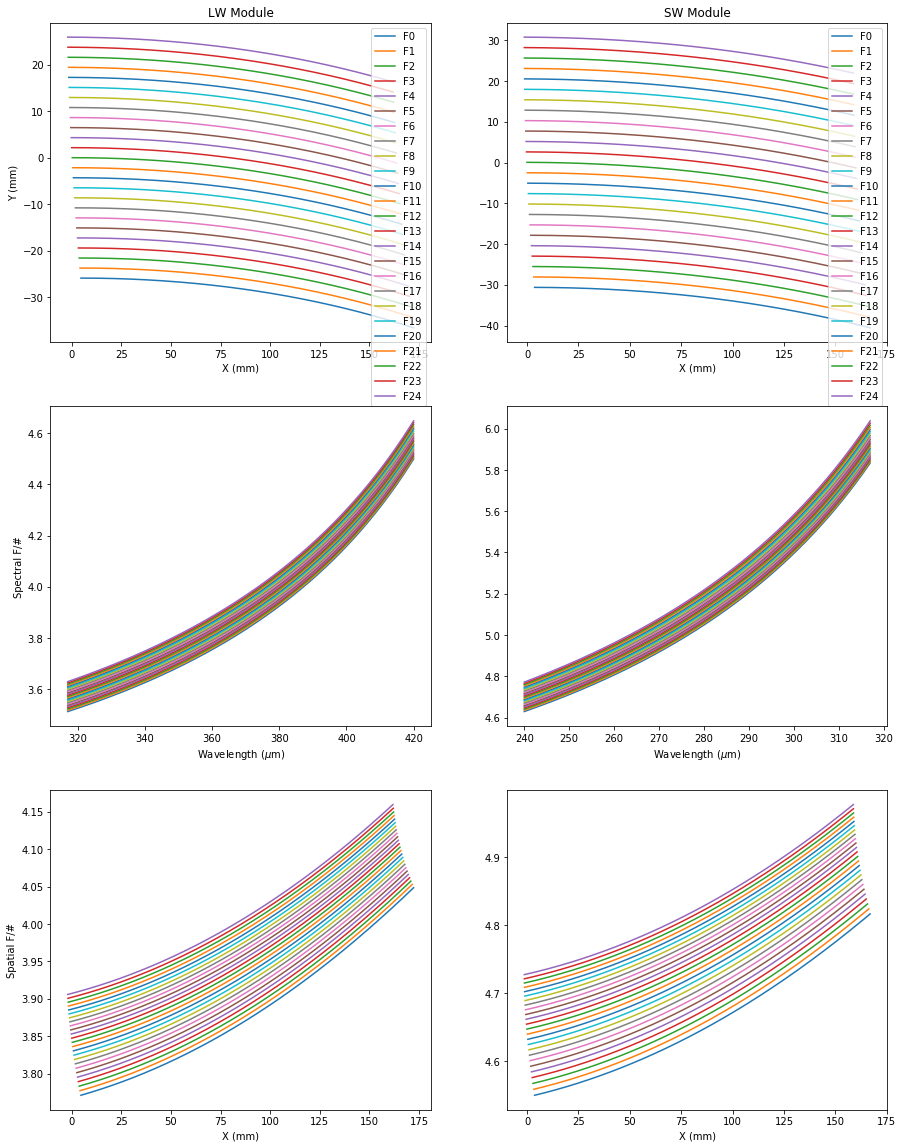

In [11]:
# Plot in the input data
def plot_spectrometer(ax, data1, data2, param_dict):
    """
    A helper function to make a graph

    Parameters
    ----------
    ax : Axes
        The axes to draw to

    data1 : array
       The x data

    data2 : array
       The y data

    param_dict : dict
       Dictionary of kwargs to pass to ax.plot

    Returns
    -------
    out : list
        list of artists added
    """
    out = ax.plot(data1, data2, **param_dict)
    return out

fig, ([axLW, axSW], [axLWFnumWav, axSWFnumWav], [axLWFnum, axSWFnum]) = plt.subplots(3,2,figsize=(15,20))
for f in range(numFields):
    plot_spectrometer(axSW, SWdata['CENX'][f], SWdata['CENY'][f], {'label': 'F{}'.format(f)})
    plot_spectrometer(axLW, LWdata['CENX'][f], LWdata['CENY'][f], {'label': 'F{}'.format(f)})
    plot_spectrometer(axSWFnumWav, wavs_SW, SWdata['SFNO'][f], {'label': 'F{}'.format(f)})
    plot_spectrometer(axLWFnumWav, wavs_LW, LWdata['SFNO'][f], {'label': 'F{}'.format(f)})
    plot_spectrometer(axSWFnum, SWdata['CENX'][f], SWdata['TFNO'][f], {'label': 'F{}'.format(f)})
    plot_spectrometer(axLWFnum, LWdata['CENX'][f], LWdata['TFNO'][f], {'label': 'F{}'.format(f)})

axLW.set_xlabel('X (mm)')
axSW.set_xlabel('X (mm)')
axLW.set_ylabel('Y (mm)')

axLWFnumWav.set_xlabel(r'Wavelength ($\mu$m)')
axSWFnumWav.set_xlabel(r'Wavelength ($\mu$m)')
axLWFnumWav.set_ylabel('Spectral F/#')

axLWFnum.set_xlabel('X (mm)')
axSWFnum.set_xlabel('X (mm)')
axLWFnum.set_ylabel('Spatial F/#')

axLW.set_title('LW Module')
axSW.set_title('SW Module')

axLW.legend()
axSW.legend()

In [12]:
# Compute the chromatic resolution for each field
bandwidth_SW = SW2 - SW1
bandwidth_LW = LW2 - LW1

avgWav_SW = SW1 + bandwidth_SW/2
avgWav_LW = LW1 + bandwidth_LW/2

numPixels = 72
pixelPitch = 2.3

centerWavs_SW_N = np.empty([numFields,numPixels])
centerWavs_LW_N = np.empty([numFields,numPixels])

centerWavs_SW_Fnum = np.empty([numFields,numPixels])
centerWavs_LW_Fnum = np.empty([numFields,numPixels])

# Detector locations based on a fixed pixel pitch
n = np.linspace(0,numPixels-1,numPixels)
det = pixelPitch*n

# Compute the F*Lambda pitch
scale = 1.5
det_SW_Fnum = scale*SWdata['SFNO']*wavs_SW/1000
det_LW_Fnum = scale*LWdata['SFNO']*wavs_LW/1000

# First, we fit the centroid data with a quadratic
for f in range(numFields):
    # Get polynomial representation
    SW_coefs = poly.polyfit(SWdata['CENX'][f], wavs_SW, 2)
    # Evaluate the polynomial at the detector locations
    centerWavs_SW_N[f] = poly.polyval(det, SW_coefs)
    
    LW_coefs = poly.polyfit(LWdata['CENX'][f], wavs_LW, 2)
    centerWavs_LW_N[f] = poly.polyval(det, LW_coefs)

# # We find the nearest entry in the array that corresponds to each pixel location.
# def find_nearest(array, value):
#     array = np.asarray(array)
#     return (np.abs(array - value)).argmin()

# for f in range(numFields):
#     for p in range(numPixels):
#         centerWavs_SW_N[f,p] = wavs_SW[find_nearest(SWdata['CENX'][f],det[p])]
#         centerWavs_LW_N[f,p] = wavs_LW[find_nearest(LWdata['CENX'][f],-1*det[p])]


# for f in range(numFields):
#     for p in range(numPixels):
#         centerWavs_SW_Fnum[f,p] = wavs_SW[find_nearest(SWdata['CENX'][f],det_SW_Fnum[f])]
#         centerWavs_LW_Fnum[f,p] = wavs_LW[find_nearest(LWdata['CENX'][f],-1*det_LW_Fnum[f])]

deltaWav_SW_N = np.gradient(centerWavs_SW_N, axis=1)
deltaWav_LW_N = np.gradient(centerWavs_LW_N, axis=1)

R_SW = avgWav_SW/deltaWav_SW_N
R_LW = avgWav_LW/deltaWav_LW_N

R_SW[np.isinf(R_SW)] = np.nan
R_LW[np.isinf(R_LW)] = np.nan

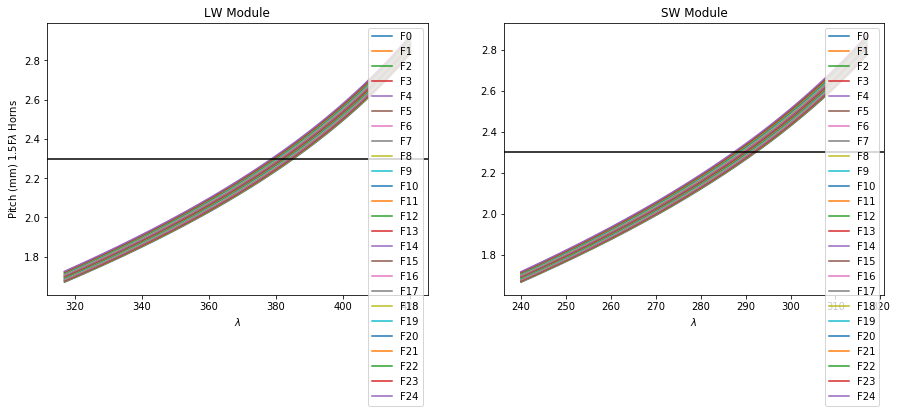

In [13]:
fig, (axLW, axSW) = plt.subplots(1,2,figsize=(15,5))
for f in range(numFields):
    plot_spectrometer(axSW, wavs_SW, det_SW_Fnum[f], {'label': 'F{}'.format(f)})
    plot_spectrometer(axLW, wavs_LW, det_LW_Fnum[f], {'label': 'F{}'.format(f)})

axLW.axhline(pixelPitch, color='k')
axSW.axhline(pixelPitch, color='k')
    
axLW.set_xlabel('$\lambda$')
axSW.set_xlabel('$\lambda$')
axLW.set_ylabel('Pitch (mm) {}F$\lambda$ Horns'.format(scale))

axLW.set_title('LW Module')
axSW.set_title('SW Module')

axLW.legend()
axSW.legend()

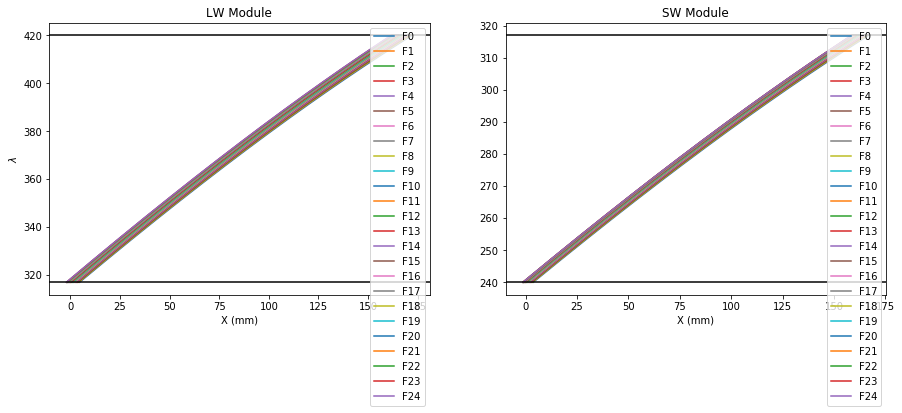

In [19]:
fig, (axLW, axSW) = plt.subplots(1,2,figsize=(15,5))
for f in range(numFields):
    plot_spectrometer(axSW, SWdata['CENX'][f], wavs_SW, {'label':'F{}'.format(f)})
    plot_spectrometer(axLW, LWdata['CENX'][f], wavs_LW, {'label':'F{}'.format(f)})

axLW.axhline(LW1, color='k')
axSW.axhline(SW1, color='k')

axLW.axhline(LW2, color='k')
axSW.axhline(SW2, color='k')
    
axLW.set_xlabel('X (mm)')
axSW.set_xlabel('X (mm)')
axLW.set_ylabel(r'$\lambda$')

axLW.set_title('LW Module')
axSW.set_title('SW Module')

axLW.legend()
axSW.legend()

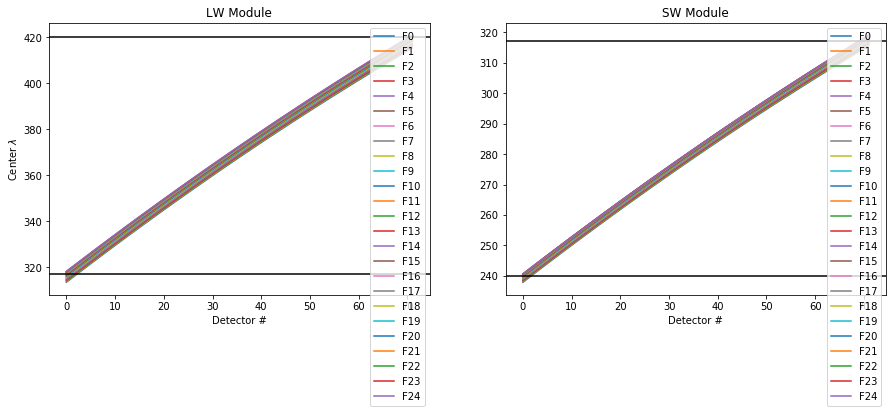

In [15]:
fig, (axLW, axSW) = plt.subplots(1,2,figsize=(15,5))
for f in range(numFields):
    plot_spectrometer(axSW, n, centerWavs_SW_N[f], {'label': 'F{}'.format(f)})
    plot_spectrometer(axLW, n, centerWavs_LW_N[f], {'label': 'F{}'.format(f)})

axLW.axhline(LW1, color='k')
axSW.axhline(SW1, color='k')

axLW.axhline(LW2, color='k')
axSW.axhline(SW2, color='k')
    
axLW.set_xlabel('Detector #')
axSW.set_xlabel('Detector #')
axLW.set_ylabel(r'Center $\lambda$')

axLW.set_title('LW Module')
axSW.set_title('SW Module')

axLW.legend()
axSW.legend()

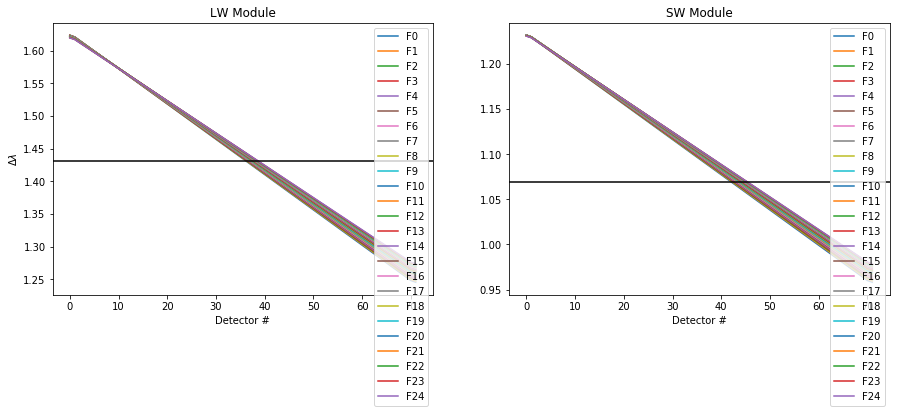

In [18]:
fig, (axLW, axSW) = plt.subplots(1,2,figsize=(15,5))
for f in range(numFields):
    plot_spectrometer(axSW, n, deltaWav_SW_N[f], {'label': 'F{}'.format(f)})
    plot_spectrometer(axLW, n, deltaWav_LW_N[f], {'label': 'F{}'.format(f)})
    
axLW.set_xlabel('Detector #')
axSW.set_xlabel('Detector #')
axLW.set_ylabel(r'$\Delta\lambda$')

axLW.set_title('LW Module')
axSW.set_title('SW Module')

axSW.axhline(bandwidth_SW/numPixels, color='k')
axLW.axhline(bandwidth_LW/numPixels, color='k')

axLW.legend()
axSW.legend()

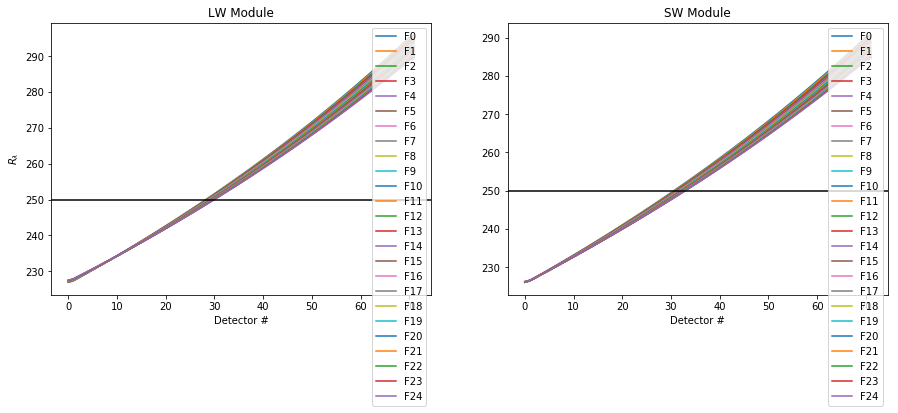

In [17]:
fig, (axLW, axSW) = plt.subplots(1,2,figsize=(15,5))
for f in range(numFields):
    plot_spectrometer(axSW, n, R_SW[f], {'label': 'F{}'.format(f)})
    plot_spectrometer(axLW, n, R_LW[f], {'label': 'F{}'.format(f)})
    
axLW.set_xlabel('Detector #')
axSW.set_xlabel('Detector #')
axLW.set_ylabel(r'$R_\lambda$')

axLW.set_title('LW Module')
axSW.set_title('SW Module')

axLW.axhline(250, color='k')
axSW.axhline(250, color='k')

axLW.legend()
axSW.legend()